# 🎓 **Taller 4.8: Taller de Método de Clustering Espectral**


## OBJETIVOS DEL TALLER:
En esta práctica vamos a poner en práctica los conceptos vistos en clase relacionados con los métodos de clustering espectral.

# 🔧 **CONFIGURACIÓN INICIAL**

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix, diags, eye, issparse
from scipy import linalg

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [13]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

Cargamos el dataset reducido, para probar este algoritmo

✅ Dataset cargado desde URL GitHub


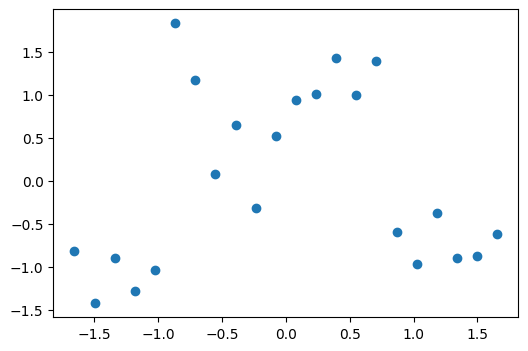

In [14]:
D =cargar_dataset("dataset_reducido.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False),:]
Dx = D[:,:2]

from sklearn.preprocessing import StandardScaler

# Crear el escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
Dx = scaler.fit_transform(Dx)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1])

# 🎯 **1:Cree el Algoritmo de Clustering Espectral**

## PASO 1: GRAFO DE SIMILITUD


### Metodo para Graficar un Grafo de Similitud


In [15]:
def plt_grafo_afinidad(Dx, A):
    # Verificar si hay conexiones
    # Normalizar pesos para grosor
    non_zero_mask = A > 0
    non_zero_vals = A[non_zero_mask]

    min_val = np.min(non_zero_vals)
    max_val = np.max(non_zero_vals)

    # Evitar división por cero
    if max_val - min_val == 0:
        aux = np.ones_like(non_zero_vals) * 0.5
    else:
        aux = (non_zero_vals - min_val) / (max_val - min_val)

    # Grosor entre 0.5 y 5
    W_scaled = 0.5 + 4.5 * aux

    # Crear matriz de grosores
    W = np.zeros_like(A, dtype=float)
    W[non_zero_mask] = W_scaled

    # Crear figura
    fig, ax = plt.subplots(figsize=(6, 4))

    # Puntos
    ax.scatter(Dx[:, 0], Dx[:, 1], s=80, c='blue', alpha=0.7)
    for i in range(Dx.shape[0]):
        ax.annotate(str(i),
                   xy=(Dx[i, 0], Dx[i, 1]),  # ¡IMPORTANTE: tupla (x, y)!
                   xytext=(3, 3),
                   textcoords='offset points')
    inds = np.where(A > 0)
    for i in range(len(inds[0])):
        idx1 = inds[0][i]
        idx2 = inds[1][i]
        # Solo graficar una vez por par (i < j)
        if idx1 < idx2:
            ax.plot([Dx[idx1, 0], Dx[idx2, 0]],
                   [Dx[idx1, 1], Dx[idx2, 1]],
                   linestyle='-',
                   linewidth=W[idx1, idx2],
                   c='red',
                   alpha=0.5)
    ax.set_title(f'Grafo de Afinidad ({len(inds[0])//2} conexiones)')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### a)	El grafo ε-vecindad

In [16]:
from sklearn.metrics.pairwise import euclidean_distances
def grafo_epsilon(Dx, epsilon, sigma=None):
    # sigma: si es None, grafo binario; si es float, pesos gaussianos
    n = Dx.shape[0]
    distancias = euclidean_distances(Dx)

    # p1 tu codigo aqui: Máscara binaria (1 si distancia < epsilon, de lo contrario 0)
    mascara = (distancias < epsilon).astype(float)

    np.fill_diagonal(mascara, 0)  # eliminar self-loops

    if sigma is None:
        # Grafo binario
        W = mascara
    else:
        # Grafo con pesos gaussianos dentro de epsilon
        W = np.exp(-distancias**2 / (2 * sigma**2))

        # p2 tu codigo aqui: Aplicar la máscara para que solo los puntos
        # dentro de epsilon mantengan su peso, el resto a cero.
        W = W * mascara

        np.fill_diagonal(W, 0)
    return W

#### Selección de ε (epsilon) y σ (sigma) en la Construcción del Grafo
1. Para ε (epsilon) - Radio de Vecindad

In [17]:
distancias = euclidean_distances(Dx)
n = distancias.shape[0]
distancias_vals = distancias[np.triu_indices(n, k=1)]
epsilon = np.median(distancias_vals)

print(f"Método: Mediana")
print(f"  Epsilon sugerido: {epsilon:.4f}")
print(f"  Proporción de conexiones: {np.mean(distancias_vals <= epsilon):.2%}")

Método: Mediana
  Epsilon sugerido: 1.9545
  Proporción de conexiones: 50.22%


2. Para σ (sigma) - Ancho del Kernel Gaussiano

In [18]:
mascara = distancias < epsilon
distancias_filtradas = distancias[mascara]
sigma = np.median(distancias_filtradas[distancias_filtradas > 0])
print(f"Sigma sugerido: {sigma:.4f}")

Sigma sugerido: 1.1317


In [19]:
# p3 tu codigo aqui: Generar la matriz de afinidad usando el epsilon y sigma calculados
W = grafo_epsilon(Dx, epsilon, sigma=sigma)

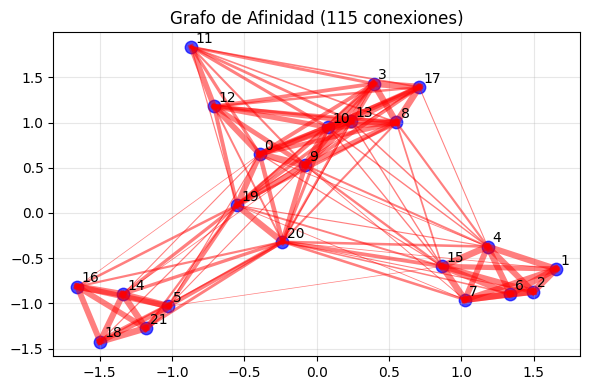

In [20]:
plt_grafo_afinidad(Dx, W)

### b)	El grafo k-Vecinos Más Cercanos (k-NN)

In [21]:
def grafo_knn(Dx, knn, sigma=None, modo='interseccion'):
    n = Dx.shape[0]
    distancias = euclidean_distances(Dx)
    W_dir = np.zeros((n, n))
    # Construir grafo dirigido de k-NN
    for i in range(n):
        # Índices de los k vecinos más cercanos (excluyendo i)
        indices = np.argsort(distancias[i])[1:knn+1]
        if sigma is None:  # Binario
            W_dir[i, indices] = 1
        else: # Gaussiano
            for j in indices:
                d = distancias[i, j]
                W_dir[i, j] = np.exp(-d**2 / (2 * sigma**2))
    # Aplicar modo de simetría
    if modo == 'dirigido':
        W = W_dir
    elif modo == 'union': # Unión: i-j conectados si i→j O j→i
        W = np.maximum(W_dir, W_dir.T)
    elif modo == 'interseccion': # i-j conectados solo si i→j Y j→i
        W = W_dir * W_dir.T
    elif modo == 'mutuo':  # verifica explícitamente vecindad mutua
        W = np.zeros((n, n))
        for i in range(n):
            vecinos_i = np.where(W_dir[i] > 0)[0]
            for j in vecinos_i:
                if W_dir[j, i] > 0:  # j también tiene a i como vecino
                    W[i, j] = W_dir[i, j]
        W = np.maximum(W, W.T)  # hacer simétrico
    np.fill_diagonal(W, 0)# Eliminar self-loops
    return W

#### 1. Para k (número de vecinos)

##### a) Regla logarítmica (para datos bien comportados):

In [22]:
n = Dx.shape[0]
k_base = int(np.log2(n)) + 1  # Mínimo razonable
k_max = int(np.sqrt(n))       # Máximo razonable
k_recomendado = min(max(k_base, 5), k_max)  # Entre 5 y sqrt(n)
print(f"k recomendado: {k_recomendado}")

k recomendado: 4


##### b) Basado en la dimensionalidad intrínseca:

In [23]:
def estimar_k_por_dimensionalidad(Dx, muestra=1000):
    if len(Dx) > muestra:
        indices = np.random.choice(len(Dx), muestra, replace=False)
        muestra_datos = Dx[indices]
    else:
        muestra_datos = Dx
    n_vecinos = 10  # Para estimación inicial
    neigh = NearestNeighbors(n_neighbors=n_vecinos+1)
    neigh.fit(muestra_datos)
    distancias, _ = neigh.kneighbors(muestra_datos)
    # Estimación simple de dimensionalidad local
    # Ratio entre distancias a vecinos consecutivos
    ratios = distancias[:, 2:] / (distancias[:, 1:-1] + 1e-10)
    dim_estimada = 1 / (np.log(ratios).mean(axis=1).mean())
    # k proporcional a dimensionalidad
    k = int(dim_estimada * 5)  # Factor empírico
    return max(5, min(k, int(np.sqrt(len(Dx)))))

In [24]:
# p4 tu codigo aqui:
k = estimar_k_por_dimensionalidad(Dx)

print(f"k estimado: {k}")

k estimado: 5


#### 2. Para σ (sigma) - Ancho Gaussiano

In [25]:
def sigma_adaptativo_por_punto(Dx, k):
    distancias = euclidean_distances(Dx)
    sigma_local = np.zeros(len(Dx))

    for i in range(len(Dx)):
        # Distancias a los k vecinos más cercanos
        dists_k = np.sort(distancias[i])[1:k+1]  # Excluir self
        # Usar la distancia al k-ésimo vecino o la media
        sigma_local[i] = dists_k[-1]  # o np.mean(dists_k)

    # Para uso global, usar la mediana
    sigma_global = np.median(sigma_local)
    return sigma_global, sigma_local

In [26]:
sigma_global, sigma_local = sigma_adaptativo_por_punto(Dx, k=31)
print(f"Sigma global: {sigma_global:.4f}")
print(f"Proporción de conexiones: {np.mean(sigma_local <= sigma_global):.2%}")

Sigma global: 3.1233
Proporción de conexiones: 50.00%


In [27]:
# p6 tu codigo aqui
W = grafo_knn(Dx, knn=k, sigma=sigma_global, modo='interseccion')

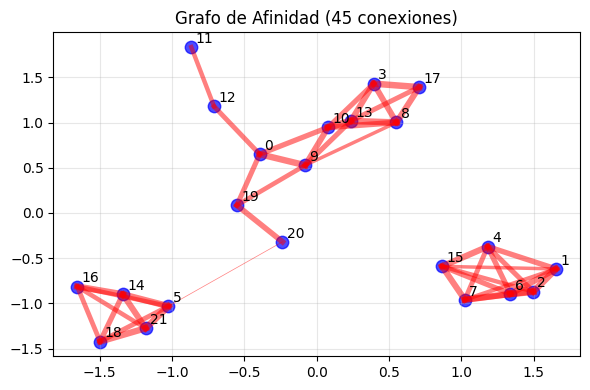

In [28]:
plt_grafo_afinidad(Dx, W)

 ## PASO 2: Calcular la Matriz Laplaciana
 Una vez obtenida la matriz de afinidad, el siguiente paso es calcular una matriz Laplaciana. Como se ha visto en la parte teórica, hay tres manera de hacerlo.

In [29]:
def laplaciano_no_normalizado(mAfinidad):

    grados = np.array(mAfinidad.sum(axis=1)).flatten()

    # Crear la matriz diagonal D
    D = np.diag(grados)

    return D - mAfinidad

In [30]:
def matriz_Laplaciana_normalizada(mAfinidad):
    D = np.sum(mAfinidad, axis=1)
    D = D**(-1)
    I = np.diag(np.ones(D.size))
    D_inv = np.diag(D)

    # p8 tu codigo aqui: I - D^-1 * W
    return I - (D_inv @ mAfinidad)

In [31]:
def matriz_Laplaciana_normalizada_simetrica(mAfinidad):
    D = np.sum(mAfinidad, axis=1)
    D = D**(-1.0/2)
    I = np.diag(np.ones(D.size))
    D_inv_sqrt = np.diag(D)

    # p9 tu codigo aqui
    return I - (D_inv_sqrt @ mAfinidad @ D_inv_sqrt)

 ## PASO 3: Análisis espectral

In [33]:
from scipy import linalg

def calcula_valores_vectores_propios(mLaplaciana, K):
    # p10 tu codigo aqui: Calcular autovalores y autovectores
    # Usamos linalg.eigh porque la matriz Laplaciana es simétrica y real
    valores_pr, vectores_pr = linalg.eigh(mLaplaciana)

    # Ordenar por valor propio ascendente
    orden = valores_pr.real.argsort()
    valores_pr = valores_pr.real[orden]
    vectores_pr = vectores_pr.real[:, orden]

    # p11 tu codigo aqui: Tomar los K autovectores correspondientes a los K autovalores más pequeños.
    # Nota: El primer autovector (índice 0) suele ser constante y asociado al autovalor 0.
    Dx_trans = vectores_pr[:, :K]

    return Dx_trans

## PASO 4: Clustering en el Espacio de Vectores Propios

In [34]:
def agrupamiento_espectral(Dx, K, afinidad, laplaciana, **kwargs):
    # Generar la matriz de afinidad (usando las funciones previas como grafo_knn o grafo_epsilon)
    mAfinidad = afinidad(Dx, **kwargs)

    # p12 tu codigo aqui: Calcular la matriz Laplaciana a partir de la de afinidad
    mLaplaciana = laplaciana(mAfinidad)

    # p13 tu codigo aqui: Obtener la proyección espectral (vectores propios)
    Dx_trans = calcula_valores_vectores_propios(mLaplaciana, K)

    # Metodo de agrupamiento
    modelo = KMeans(n_clusters=K, n_init=10)
    modelo = modelo.fit(Dx_trans)

    # p14 tu codigo aqui: Obtener las etiquetas de los clústeres asignados
    Dyp = modelo.labels_

    return [mAfinidad, Dyp]

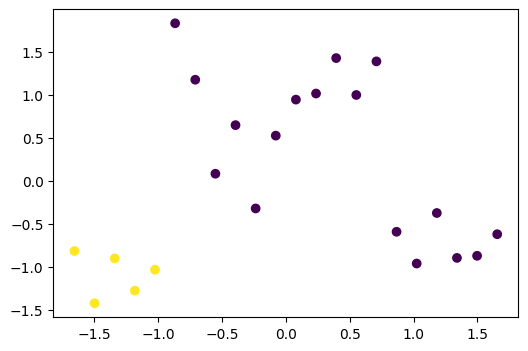

In [35]:
# p15 tu codigo aqui
K = 2
epsilon = epsilon
sigma = sigma

mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma=sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp, cmap='viridis')
plt.show()

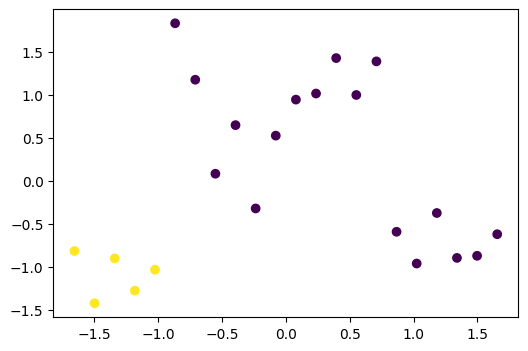

In [36]:
# p16 tu codigo aqui
K = 2
epsilon = epsilon
sigma = sigma

mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma=sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp, cmap='viridis')
plt.show()

# 🎯 **2:Pruebe el Algoritmo de Clustering Espectral**

✅ Dataset cargado desde URL GitHub


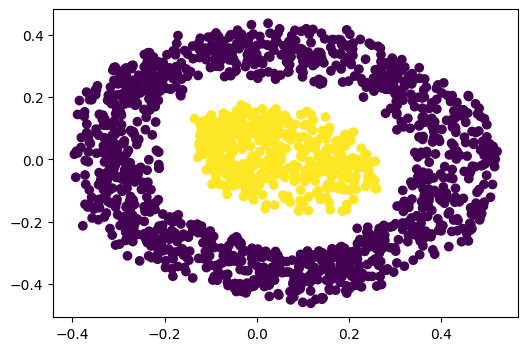

In [37]:
D =cargar_dataset("dataset_circulos_concentricos.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

## Con el grafo ε-vecindad  y laplaciano no Normalizado

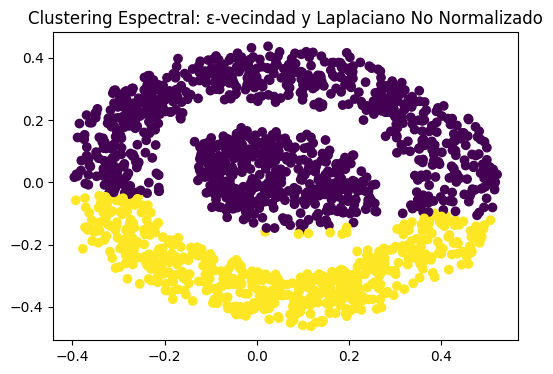

In [38]:
# p17 tu codigo aqui
K = 2
epsilon = 0.2  # Ajustado según la escala típica de círculos concéntricos
sigma = 0.1    # Ancho del kernel gaussiano para suavizar la afinidad

mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_epsilon, laplaciano_no_normalizado, epsilon=epsilon, sigma=sigma)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp, cmap='viridis')
ax.set_title("Clustering Espectral: ε-vecindad y Laplaciano No Normalizado")
plt.show()

## Con El grafo k-Vecinos

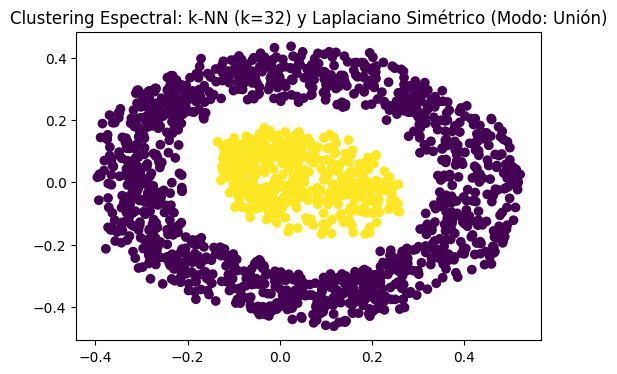

In [42]:
# p18 tu codigo aqui
K = 2


current_k = estimar_k_por_dimensionalidad(Dx)
current_sigma_global, _ = sigma_adaptativo_por_punto(Dx, k=current_k)


mAfinidad, Dyp = agrupamiento_espectral(
    Dx, K, grafo_knn, matriz_Laplaciana_normalizada_simetrica,
    knn=current_k, sigma=current_sigma_global, modo='union'
)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp, cmap='viridis')
ax.set_title(f"Clustering Espectral: k-NN (k={current_k}) y Laplaciano Simétrico (Modo: Unión)")
plt.show()


## Cambiado de Laplaciano


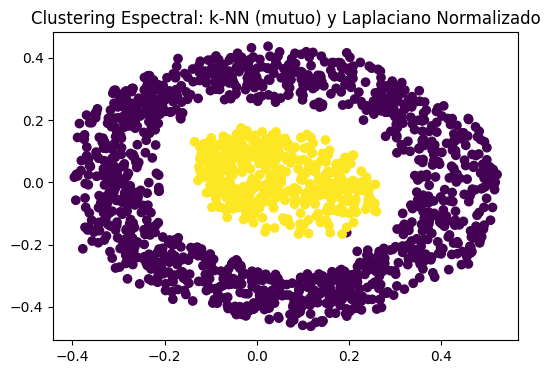

In [43]:
# p19 tu codigo aqui
K = 2
knn = 31 # Valor robusto para asegurar conectividad en modo mutuo
sigma = sigma_global
modo = 'mutuo'

mAfinidad, Dyp = agrupamiento_espectral(Dx, K, grafo_knn, matriz_Laplaciana_normalizada,
                                        knn=knn, sigma=sigma, modo=modo)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp, cmap='viridis')
ax.set_title(f"Clustering Espectral: k-NN ({modo}) y Laplaciano Normalizado")
plt.show()

<hr>
Experimente con el dataset dos remolinos


In [ ]:
D =cargar_dataset("dataset_dos_remolinos.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


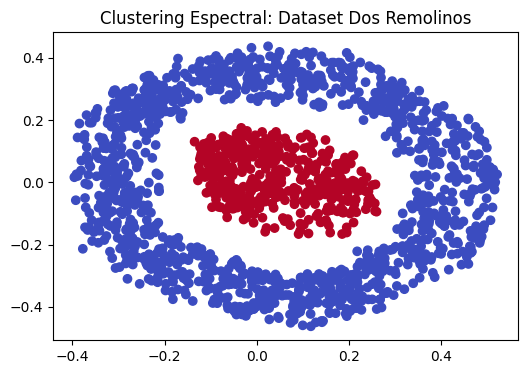

In [44]:
# p20 tu codigo aqui
K = 2
# Para espirales, un k más pequeño ayuda a no conectar ramas diferentes
knn = 10
# Calculamos sigma local para adaptarnos a la curvatura del remolino
sigma_global_rem, _ = sigma_adaptativo_por_punto(Dx, k=knn)
modo = 'union' # 'union' es más seguro para evitar que la espiral se rompa en pedazos

mAfinidad, Dyp = agrupamiento_espectral(
    Dx, K, grafo_knn, matriz_Laplaciana_normalizada_simetrica,
    knn=knn, sigma=sigma_global_rem, modo=modo
)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp, cmap='coolwarm')
ax.set_title("Clustering Espectral: Dataset Dos Remolinos")
plt.show()


Experimente con el dataset cuatro diferente medida

In [ ]:
D =cargar_dataset("dataset_cuatro_diferente_medida.xlsx")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,1:3]
Dy = D[:,3]

✅ Dataset cargado desde URL GitHub


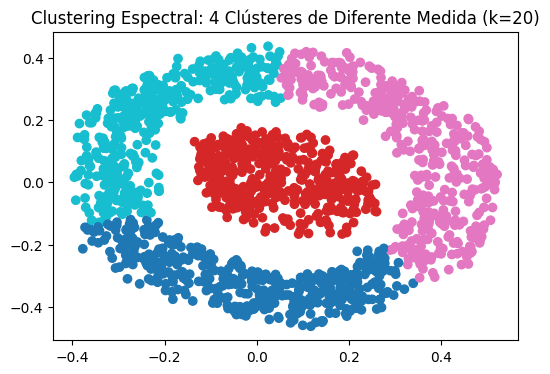

In [46]:
# p21 tu codigo aqui
K = 4
knn = 20
current_sigma, _ = sigma_adaptativo_por_punto(Dx, k=knn)

mAfinidad, Dyp = agrupamiento_espectral(
    Dx, K, grafo_knn, matriz_Laplaciana_normalizada_simetrica,
    knn=knn, sigma=current_sigma, modo='union'
)

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Dx[:,0], Dx[:,1], c=Dyp, cmap='tab10')
ax.set_title(f"Clustering Espectral: 4 Clústeres de Diferente Medida (k={knn})")
plt.show()


<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo de clustering espectral.

Están implementadas (parámetro affinity) las matrices de afinidad completa y KNN. Usa la matriz Laplaciana normalizada.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


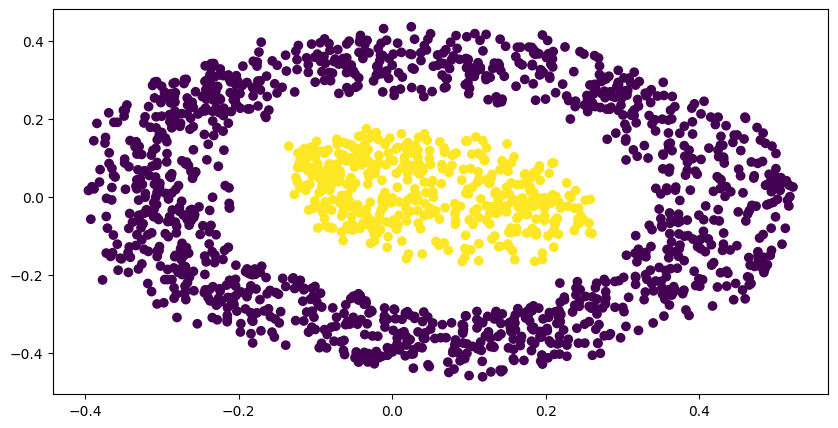

In [47]:
from sklearn.cluster import SpectralClustering
K = 2
knn = 5
clustering = SpectralClustering(n_clusters = K,
                                affinity = 'nearest_neighbors', n_neighbors = knn,
                                random_state = 0).fit(Dx)

fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)

Que metodo funciona mejor para los 5 Dataset y porque?


*   dataset_circulos_concentricos

MEJOR METDODO: Clustering Espectral con Grafo e-vecindad y Laplaciano No Normalizado.

En este dataset, la separación entre los anillos es constante y clara. El grafo de $\epsilon$-vecindad captura perfectamente la continuidad geométrica de cada anillo. Al tener una densidad similar en ambos anillos, el Laplaciano No Normalizado es suficiente para identificar los componentes conectados sin necesidad de normalización compleja.

*   dataset_cuatro_diferente_densidad

MEJOR METODO:Clustering Espectral con Grafo k-NN y Laplaciano Normalizado Simétrico.

Cuando las densidades varían, el grado de los nodos es muy distinto. El Laplaciano Normalizado ($L_{sym}$) "suaviza" estas diferencias, evitando que el grupo más denso atraiga todos los autovectores. El grafo k-NN asegura que cada punto tenga conexiones independientemente de qué tan disperso esté el grupo.

*   dataset_cuatro_separables_peque

MEJOR METODO:K-Means estándar (o Espectral con Grafo k-NN y Laplaciano No Normalizado).

Al ser grupos pequeños, compactos y bien separados (convexos), no requieren la complejidad del clustering espectral. K-means los resuelve con menor costo computacional. Si se usa Espectral, un k-NN pequeño basta para definir los grupos.

*   dataset_cuatro_diferente_medida

MEJOR METODO: Clustering Espectral con Grafo k-NN (Modo Unión) y Laplaciano Normalizado de Shi-Malik (o Simétrico).

Al tener diferentes tamaños (medidas), el algoritmo debe balancear el "corte" del grafo. La normalización es crítica aquí para que el algoritmo no intente separar los puntos basándose solo en el número de conexiones, sino en la proporción de volumen de cada clúster.

*   dataset_inseparable

MEJOR METODO:Clustering Espectral con Grafo k-NN (Modo Mutuo) y Laplaciano Normalizado.

El dataset "inseparable" suele tener puntos de ruido que conectan grupos que deberían estar separados. El Modo Mutuo es el más restrictivo: solo conecta puntos si ambos son vecinos cercanos entre sí, lo que actúa como un filtro de ruido que "rompe" las conexiones falsas que hacen que los datos parezcan inseparables.



# 🚀 ¡TALLER FINALIZADO!"